In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import pylab as plt
plt.style.use('fivethirtyeight')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Read data

In [3]:
data = pd.read_csv('./data/EF_battles_corrected.csv', parse_dates=['start', 'end'])

In [4]:
data['end_num'] = (data['end'].dt.year -1938) * 12 +  data['end'].dt.month
data['start_num'] = (data['start'].dt.year -1938) * 12 +  data['start'].dt.month
data['duration'] = (data['end_num'] - data['start_num']).clip(lower=1)

In [5]:
cols = [
    'allies_infantry', 'axis_infantry',
    'allies_tanks', 'axis_tanks',
    'allies_guns', 'axis_guns'
]


In [6]:
data['result_num'] = data['result'].map({'axis':-1, 'allies':1}).fillna(0)  # 0 for tie

In [7]:
data['result_num'].value_counts()

-1.0    93
 1.0    34
 0.0     6
Name: result_num, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
mask = data[cols].isnull().any(1)
X = data.loc[~mask, cols]
y = data.loc[~mask, 'result_num']

In [10]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, 
                                                y, 
                                                test_size=0.2, random_state=2018)

In [11]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()

Xtrains = s.fit_transform(Xtrain)
Xtests = s.transform(Xtest) # used mean and std from Xtrain

# 2. Supervised Learning

### KNN

In [12]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5) # again, arbitrary number
model.fit(Xtrains, ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [13]:
ypred1 = model.predict(Xtest)
accuracy_score(ytest, ypred1)

0.5

In [14]:
ytrain

4     -1.0
27    -1.0
126    1.0
71     1.0
111    1.0
70     1.0
84     1.0
118   -1.0
128    1.0
54     1.0
98     1.0
55     1.0
73     1.0
42    -1.0
66    -1.0
Name: result_num, dtype: float64

### Showing "Neighbors" - similar records

In [44]:
data.loc[106]

name                                                  Battle of the Dukla Pass
url                          https://en.wikipedia.org/wiki/Battle_of_the_Du...
allies killed                                                            10060
axis killed                                                              70000
allies_destroyed_tanks                                                       0
allies_destroyed_airplane                                                    0
allies_destroyed_guns                                                        0
axis_destroyed_tanks                                                         0
axis_destroyed_airplane                                                      0
axis_destroyed_guns                                                          0
belligerents.allies                              Soviet Union   Czechoslovakia
belligerents.axis                                            Germany   Hungary
axis_leaders                      Gotthard Heinrici,

In [15]:
Xtest.head(1)

,allies_infantry,axis_infantry,allies_tanks,axis_tanks,allies_guns,axis_guns
106,378000.0,100000.0,1000.0,350.0,3241.0,2000.0


In [16]:
Xtrain.iloc[model.kneighbors(Xtest.head(1))[1][0]]

,allies_infantry,axis_infantry,allies_tanks,axis_tanks,allies_guns,axis_guns
55,1173500.0,1040000.0,894.0,950.0,13451.0,3000.0
66,1286000.0,300700.0,2409.0,625.0,26379.0,5500.0
98,1002200.0,900000.0,1979.0,900.0,11265.0,6300.0
126,1171800.0,270000.0,1600.0,772.0,5425.0,434.0
73,822000.0,500000.0,550.0,146.0,4600.0,2389.0


In [51]:
data.loc[[106, 55, 66,98, 126, 73], 'start']

106   1944-09-01
55    1942-11-01
66    1943-07-01
98    1944-07-01
126   1945-04-01
73    1944-01-01
Name: start, dtype: datetime64[ns]

# Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import median_absolute_error

In [18]:
cols = [
    'allies_infantry', 'axis_infantry',
    'allies_tanks', 'axis_tanks',
    'allies_guns', 'axis_guns',
    'start_num'
]


In [19]:
mask = data[cols + ['allies killed']].isnull().any(1)

In [20]:
y = data.loc[~mask, 'allies killed']
X = data.loc[~mask, cols]

In [21]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, 
                                                y, 
                                                test_size=0.3, random_state=2019)

In [22]:
model = LinearRegression()
model.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
ypred = model.predict(Xtest)

In [24]:
median_absolute_error(ytest, ypred)

42584.419274116095

In [25]:
(ypred - ytest)

111    4.934710e+04
27    -3.582174e+04
42     2.148667e+04
106   -1.191980e+03
54    -1.007381e+06
49    -9.226890e+05
Name: allies killed, dtype: float64

In [26]:
pd.Series(model.coef_, index=X.columns)

allies_infantry     0.024922
axis_infantry       0.079912
allies_tanks      -25.215543
axis_tanks        -19.178557
allies_guns         3.797002
axis_guns           0.387496
start_num         -50.093280
dtype: float64

# Decision tree

In [52]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from io import StringIO
from IPython.display import Image  
import pydotplus

In [53]:
cols = [
    'allies_infantry', 'axis_infantry',
    'allies_tanks', 'axis_tanks',
    'allies_guns', 'axis_guns'
]


In [54]:
mask = data[cols].isnull().any(1)
X = data.loc[~mask, cols]
y = data.loc[~mask, 'result_num']

In [55]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, 
                                                y, 
                                                test_size=0.2, random_state=2019)

In [56]:
tree_model = DecisionTreeClassifier(random_state=2019)
tree_model.fit(Xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=2019, splitter='best')

In [57]:
accuracy_score(ytest, tree_model.predict(Xtest))

0.5

In [58]:
tree_model.predict(Xtest)

array([ 1.,  1.,  1., -1.])

## Visualize the graph

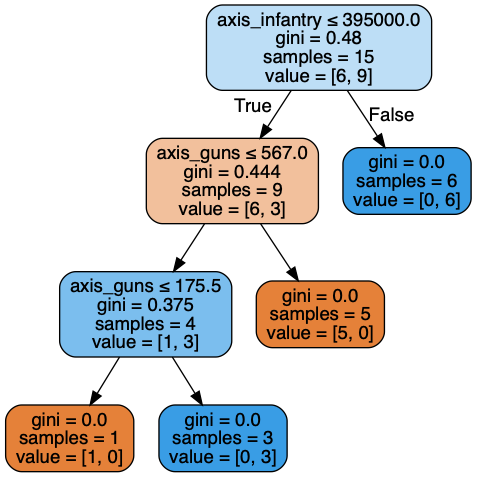

In [59]:
dot_data = StringIO()

export_graphviz(tree_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=cols)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())